## DSCI 100 Project Proposal Team 44

# Project Title: Determining The Best Predictors Heart Disease

## Introduction

Heart disease or failure is a condition where the heart muscle of the afflicted cannot pump blood as efficiently due to a structural defect, compared to a person without the condition. Quick diagnosis and implementation of treatments may be able to drastically improve someone's chances of living through heart disease.

The question we will be trying to answer with our project is the following: 
Which attributes are the best and worst for predicting heart disease? What attributes are relevant?

In this project, we hope to accomplish the following three things:
1. Make a training model that can accurately predict whether a person has a heart disease given certain classifiers and what stage of heart disease they have.
2. Determine the correlation of heart disease with the 13 classifiers excluding num. (See Appendix) 
3. Compare the accuracy of models trained under specific classifiers by testing the result of the predictions against the clinical data.

We will be using the processed Cleveland data provided by the UCI Machine Learning Repository. The main attributes we will be looking into include the ones numbered 1-14 as seen on the listed attributes on the website. Initially, there were 6 observations that contained missing information that we decided to remove from the overall data set we decided to use. All columns of the data set contain quantitative data with certain values corresponding to a meaning. 


## Preliminary Data Analysis

In [49]:
#install.packages("corrplot")

In [50]:
#Loading relevant libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(corrplot)

In [51]:
#Loading and formatting the data

data <- read_delim("processed.cleveland.data", delim =",", col_names = FALSE)

attributes <-  c("age", 'sex','cp', 'trestbps', 'chol', 'fbs', 'restecg',
                 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num')
colnames(data) <- attributes

head(data)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [52]:
#Determining if the data has NA values
na_count <-sapply(data, function(y) sum(length(which(is.na(y)))))
na_count <- data.frame(na_count)
na_count #no missing values were found upon initial inspection 

,na_count
,<int>
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0


In [53]:
#Note: the columns ca and thal load as character types as they contain non-numeric values as placeholders for missing data.
#R does this as default to preserve information. Convert to numeric types then filter to remove NA values 

data <- data %>%
  mutate(oldpeak = as.numeric(oldpeak),
         ca = as.numeric(ca),
         thal = as.numeric(thal)) %>% 
  filter(!is.na(ca),
         !is.na(thal))

head(data)

Warning message:
“Problem with `mutate()` input `ca`.
ℹ NAs introduced by coercion
ℹ Input `ca` is `as.numeric(ca)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `thal`.
ℹ NAs introduced by coercion
ℹ Input `thal` is `as.numeric(thal)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


In [54]:
# Split dataset into training/testing --------------------------------------

heart_split <- initial_split(data, prop = 0.8, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train_explore <- heart_train %>% 
  mutate(disease = ifelse(num > 0,"disease","healthy")) %>% 
  mutate(sex_char = ifelse(sex == 1 ,"male","female")) %>% 
  mutate(num_b = ifelse(num > 0, 1, 0)) #binarizes the heart disease status as either present (1) or absent (0)

In [55]:
# Exploratory Tables ------------------------------------------------------
heart_proportions <- heart_train %>% 
  group_by(num) %>% 
  summarize(n = n()) %>% 
  mutate(percent = 100*n/nrow(heart_train))%>%
  rename("disease" = num,
         "count" = n)
heart_proportions

heart_proportions_2 <- heart_train_explore %>% 
  group_by(disease) %>% 
  summarize(n = n()) %>% 
  mutate(percent = 100*n/nrow(heart_train_explore))%>%
  rename("status" = disease,
         "count" = n)
heart_proportions_2

summary <- heart_train %>%
  pivot_longer(everything()) %>%
  arrange(name) %>%
  group_by(name) %>%
  summarize(
    mean = mean(value),
    std_dev = sd(value),
    median = median(value),
    max = max(value),
    min = min(value),
    quartile.1 = quantile(value, 0.25),
    quartile.3 = quantile(value, 0.75)) %>%
  rename("predictor" = name)
summary

#Correlation matrix
cor_hr <- heart_train_explore %>% 
  select(-c(sex_char, disease)) %>% 
  cor()
round(cor_hr,2)

num_char <- heart_train_explore %>% 
  select(disease, num, sex, sex_char, age) %>% 
  group_by(num, sex_char) %>% 
  summarise(n = n())

#Export dataframes
# write.table(summary, file = "heart_summary_stats.csv", row.names = FALSE)
# write.table(heart_proportions, file = "strata_num.csv",row.names = FALSE)
# write.table(heart_proportions_2, file = "strata_num_consolidated.csv",row.names = FALSE)

`summarise()` ungrouping output (override with `.groups` argument)



disease,count,percent
<dbl>,<int>,<dbl>
0,128,53.333333
1,45,18.750000
2,28,11.666667
3,29,12.083333
4,10,4.166667


`summarise()` ungrouping output (override with `.groups` argument)



status,count,percent
<chr>,<int>,<dbl>
disease,112,46.66667
healthy,128,53.33333


`summarise()` ungrouping output (override with `.groups` argument)



predictor,mean,std_dev,median,max,min,quartile.1,quartile.3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age,54.1875000,9.2271571,56.0,77.0,29,47,60.25
ca,0.6791667,0.9469083,0.0,3.0,0,0,1.00
chol,248.4083333,53.0191401,243.0,564.0,126,211,281.25
cp,3.1666667,0.9795681,3.0,4.0,1,3,4.00
exang,0.3291667,0.4708927,0.0,1.0,0,0,1.00
fbs,0.1333333,0.3406451,0.0,1.0,0,0,0.00
num,0.9500000,1.2296885,0.0,4.0,0,0,2.00
oldpeak,1.0254167,1.1512318,0.6,5.6,0,0,1.60
restecg,0.9625000,0.9950978,0.0,2.0,0,0,2.00


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,num_b
age,1.00,-0.08,0.12,0.29,0.22,0.09,0.10,-0.37,0.15,0.23,0.20,0.39,0.18,0.23,0.25
sex,-0.08,1.00,0.01,-0.06,-0.19,0.03,0.03,-0.05,0.15,0.13,0.04,0.09,0.38,0.23,0.28
cp,0.12,0.01,1.00,-0.02,0.12,-0.02,0.09,-0.33,0.38,0.18,0.15,0.22,0.28,0.38,0.37
trestbps,0.29,-0.06,-0.02,1.00,0.13,0.20,0.16,-0.05,0.09,0.19,0.15,0.11,0.14,0.19,0.18
chol,0.22,-0.19,0.12,0.13,1.00,-0.02,0.17,-0.01,0.09,0.09,0.06,0.16,0.07,0.13,0.14
fbs,0.09,0.03,-0.02,0.20,-0.02,1.00,0.04,0.01,-0.01,0.03,0.01,0.20,0.09,0.12,0.05
restecg,0.10,0.03,0.09,0.16,0.17,0.04,1.00,-0.02,0.08,0.11,0.10,0.09,0.04,0.18,0.17
thalach,-0.37,-0.05,-0.33,-0.05,-0.01,0.01,-0.02,1.00,-0.40,-0.38,-0.43,-0.27,-0.35,-0.41,-0.42
exang,0.15,0.15,0.38,0.09,0.09,-0.01,0.08,-0.40,1.00,0.32,0.26,0.18,0.40,0.45,0.45
oldpeak,0.23,0.13,0.18,0.19,0.09,0.03,0.11,-0.38,0.32,1.00,0.60,0.27,0.35,0.51,0.44


`summarise()` regrouping output by 'num' (override with `.groups` argument)



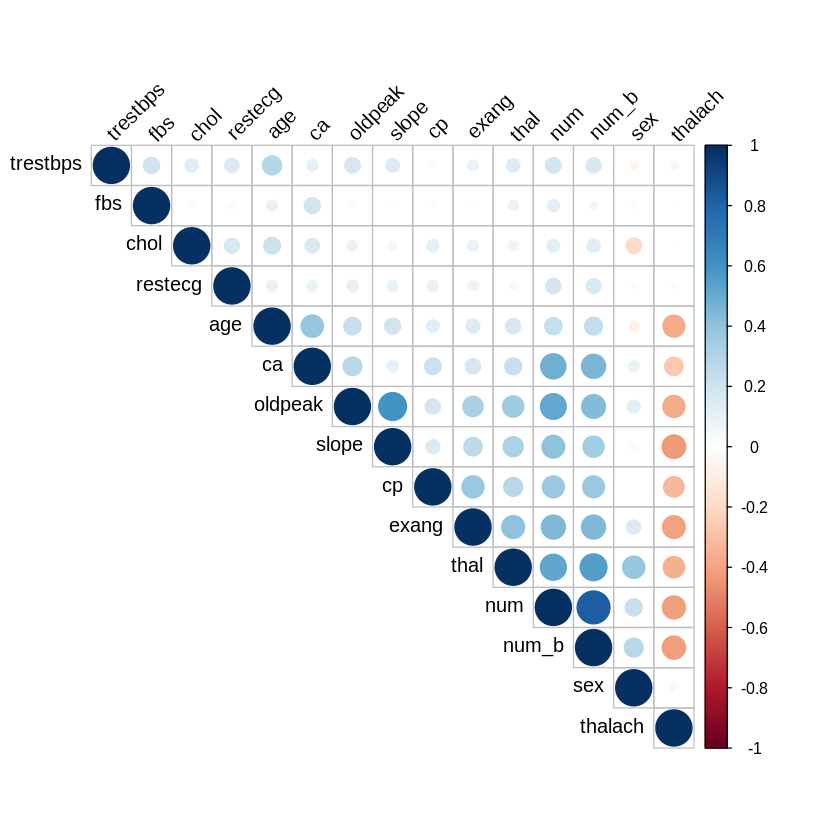

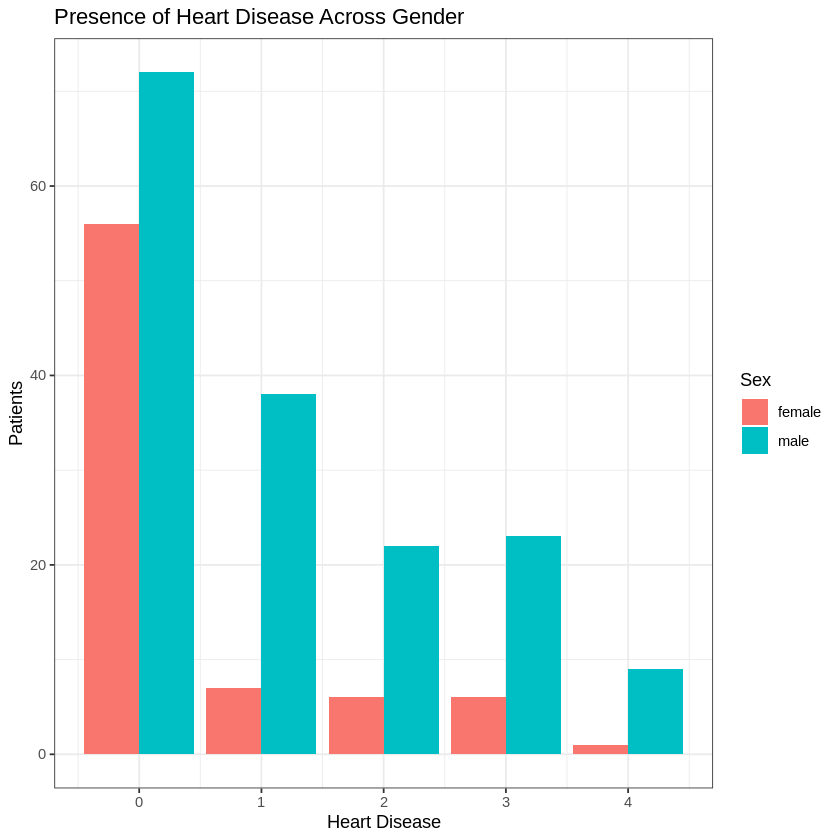

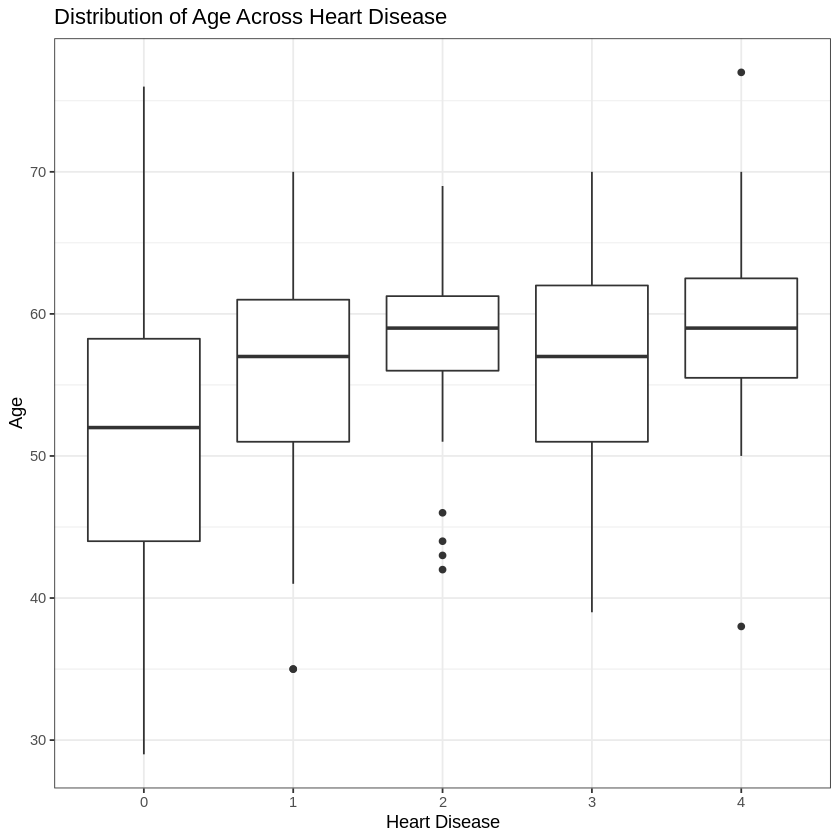

In [56]:
# Visualizations ----------------------------------------------------------
#Correlation matrix plot
corrplot(cor_hr, type = "upper", order = "hclust", 
         tl.col = "black", tl.srt = 45)

#weak correlation with each other suggests there are no confounding variables in the data

#Grouped barchart for sex vs heart disease
sex_bar_plot <- num_char %>% 
  ggplot(aes(x = num, y = n, fill = sex_char))+
  geom_bar(position="dodge", stat="identity")+
  labs(x = "Heart Disease", y = "Patients", fill = "Sex")+
  theme_bw()+
  ggtitle("Presence of Heart Disease Across Gender")
sex_bar_plot

#Sex bias is seen in heart diesease incidence rates

#age box plot
age_box_plot <- heart_train_explore %>% 
  ggplot(aes(x= as.factor(num), y = age))+
  geom_boxplot()+
  labs(x = "Heart Disease", y = "Age")+
  theme_bw()+
  ggtitle("Distribution of Age Across Heart Disease")
age_box_plot

#No apparent age bias present

## Methods
All of the variables will be considered to determine which of the predictors are best suited for predicting heart disease and which ones are irrelevant and negatively affect accuracy. We will be using the forward selection method of choosing the best predictors due to better processing time over the best-subset selection method. 

We will be visualizing the data as follows:

1. To find the ideal k value we will use a line+point graph that plots neighbors vs estimated accuracies to identify what k value yields the most accurate results.
2. To find the best number of predictors, we will plot an estimated accuracy vs. number of predictors line and point graph
3. To visualize model accuracy, we will plot a bar graph that displays the number of false-positive, true positive, false negative, and true negative results.



## Expected Outome and Significance

### Expectations
We expect to find that not all of the original predictors are required to create the most accurate classifier.  As shown through the correlation matrix and accompanying plot, some attributes do not appear to have a strong correlation with heart disease. 

### Implications
The findings could help practitioners diagnose heart disease more accurately, by only considering relevant predictor metrics. This classifier could also be used to perform a preliminary screen on who is likely to have heart disease and require a more extensive follow-up for an official diagnosis. By identifying what metrics are relevant to the prognosis of heart disease, these could be tracked to monitor patient progression.

### Future Questions 
Since only the Cleveland dataset was used to train the classifier, there could be a geographical bias. A future direction could be to analyze the accuracy of the classifier for other areas and datasets.  

## References

Heart Disease Data Set. (1988, July 1). UCI Machine Learning Repository. Retrieved   March 5, 2022, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease

NHS. (n.d.). NHS choices. Retrieved March 5, 2022, from https://www.nhs.uk/conditions/coronary-heart-disease/

## Appendix

| Attribute      | Description |
| ----------- | ----------- |
| age         | age       |
| sex         | sex         |
| cp          | chest pain |
| trestbps    | resting blood pressure |
| chol        | cholesterol |
| fbs         | fasting blood sugar |
| restecg     | resting electrocardiographic results |
| thalach     | maximum heart rate record |
| exang       | exercise induced angia |
| oldpeak     | ST depression indiced by exercise relative to rest |
| slope       | slope of peak exercise ST segment |
| ca          | number of major vessels coloured by fluoroscopy |
| thal        | thalassemia |
| num         | predicted attribute |



